In [1]:
import pandas as pd
import re
import string

In [2]:
from google.colab import files
uploaded = files.upload()

Saving True.csv.zip to True.csv.zip
Saving Fake.csv.zip to Fake.csv.zip


In [3]:
!unzip True.csv.zip
!unzip Fake.csv.zip

Archive:  True.csv.zip
  inflating: True.csv                
Archive:  Fake.csv.zip
  inflating: Fake.csv                


In [4]:
fake=pd.read_csv("Fake.csv")
true=pd.read_csv("True.csv")
# Add label columns
fake['label'] =1
true['label'] =0

In [5]:
# Combine them
data=pd.concat([fake, true])
'''
Dataset columns:

Title: title of news article
Text: body text of news article
Subject: subject of news article
Date: publish date of news article
'''
# Handle empty text
data['full_text']=data['title']+" "+data['text'].fillna('')

data.head(3)

,title,text,subject,date,label,full_text
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...


In [6]:
#Contractions mapping
contraction={
    "can't": "cannot",
    "won't": "will not",
    "i'm": "i am",
    "they're": "they are",
    "isn't": "is not",
    "don't": "do not",
    "didn't": "did not",
    "it's": "it is",
    "couldn't": "could not"
}

In [7]:
#Emoticon patterns
emoticon_pattern= r'(:\)|:\(|:D|:P|;\)|:-\)|:-\(|XD|xD|<3|¯\\_\(ツ\)_/¯)'

Custom tokenizer

In [8]:
def custom_tokenizer(text):
  #handle casing
  text=text.lower()

  #handle contractions
  for contract, expanded in contraction.items():
    text= text.replace(contract, expanded)

  #handle emoticons
  text=re.sub(emoticon_pattern, r'<EMOTICON>', text)  #replace emoticons with token

  #handle punctuation
  text=text.translate(str.maketrans('', '', string.punctuation))   #removes all punctuation marks from the text

  #handle elongated words
  def handle_elongated(match):
    repeated= match.group(1)
    count= len(match.group(0))
    return f"{repeated} <REPEAT:{count}>"

  text= re.sub(r'(.)\1{2,}',handle_elongated,text)  #replace elongated words with 3 or more repeats

  #finally tokenise
  tokens= text.split()
  return tokens

POS tagger

In [9]:
def mini_pos_tagger(tokens):
  pos= []
  for word in tokens:
    if word in ['is','are','was','were','be', 'being','been','am','have','has','had','do','does','did']:
      pos.append((word, 'verb'))
    elif re.match(r'.+ing$', word):
      pos.append((word, 'verb'))
    elif re.match(r'.+ed$', word):
      pos.append((word, 'verb'))
    elif re.match(r'.+ous$|.+ful$|.+able$|.+ible$|.+ic$|.+ive$|.+ly$', word):
      pos.append((word, 'adj'))
    else:
      pos.append((word, 'noun'))  #default to noun

  return pos


In [10]:
#apply custom tokenizer
data['tokens']= data['full_text'].apply(custom_tokenizer)

#apply POS tagger
data['pos']= data['tokens'].apply(mini_pos_tagger)

data[['full_text', 'tokens', 'pos']].head()

,full_text,tokens,pos
0,Donald Trump Sends Out Embarrassing New Year’...,"[donald, trump, sends, out, embarrassing, new,...","[(donald, noun), (trump, noun), (sends, noun),..."
1,Drunk Bragging Trump Staffer Started Russian ...,"[drunk, bragging, trump, staffer, started, rus...","[(drunk, noun), (bragging, verb), (trump, noun..."
2,Sheriff David Clarke Becomes An Internet Joke...,"[sheriff, david, clarke, becomes, an, internet...","[(sheriff, noun), (david, noun), (clarke, noun..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"[trump, is, so, obsessed, he, even, has, obama...","[(trump, noun), (is, verb), (so, noun), (obses..."
4,Pope Francis Just Called Out Donald Trump Dur...,"[pope, francis, just, called, out, donald, tru...","[(pope, noun), (francis, noun), (just, noun), ..."


Custom lemmatizer

In [11]:
def lemmatizer(pos_tokens):
    #irregular verbs
    irregular_verbs= {
        'does':'do',
        'goes':'go',
        'has':'have',
        'was':'be',
        'were':'be'
    }

    lemmas= []

    for token, pos in pos_tokens:
        lemma= token
        if pos== 'verb':
            if lemma in irregular_verbs:
                lemma= irregular_verbs[lemma]
            elif lemma.endswith('ing') and len(lemma)> 4:
                lemma= lemma[:-3]  #remove 'ing'
            elif lemma.endswith('ed') and len(lemma)> 3:
                lemma= lemma[:-2]  #remove 'ed'
            elif lemma.endswith('s') and len(lemma)> 3:
                lemma= lemma[:-1]  #remove 's' for simple present verbs
        elif pos== 'noun':
            if lemma.endswith('s') and len(lemma)> 3:
                lemma= lemma[:-1]  #plural to singular
        elif pos== 'adj':
            if lemma.endswith('ly') and len(lemma)> 4:
                lemma= lemma[:-2]  #remove 'ly'
            elif lemma.endswith('ful') and len(lemma)> 5:
                lemma= lemma[:-3]  #remove 'ful'

        lemmas.append(lemma)

    return lemmas


In [12]:
#apply lemmatizer
data['lemmatized']= data['pos'].apply(lemmatizer)

data.head()

,title,text,subject,date,label,full_text,tokens,pos,lemmatized
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,Donald Trump Sends Out Embarrassing New Year’...,"[donald, trump, sends, out, embarrassing, new,...","[(donald, noun), (trump, noun), (sends, noun),...","[donald, trump, send, out, embarrass, new, yea..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,Drunk Bragging Trump Staffer Started Russian ...,"[drunk, bragging, trump, staffer, started, rus...","[(drunk, noun), (bragging, verb), (trump, noun...","[drunk, bragg, trump, staffer, start, russian,..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,Sheriff David Clarke Becomes An Internet Joke...,"[sheriff, david, clarke, becomes, an, internet...","[(sheriff, noun), (david, noun), (clarke, noun...","[sheriff, david, clarke, become, an, internet,..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,Trump Is So Obsessed He Even Has Obama’s Name...,"[trump, is, so, obsessed, he, even, has, obama...","[(trump, noun), (is, verb), (so, noun), (obses...","[trump, is, so, obsess, he, even, have, obama’..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,Pope Francis Just Called Out Donald Trump Dur...,"[pope, francis, just, called, out, donald, tru...","[(pope, noun), (francis, noun), (just, noun), ...","[pope, franci, just, call, out, donald, trump,..."


In [13]:
#now we need to implement BoW using scikit learn. To use Scikit learn for this we need to have documents as strings and not tokens. therefore we join the lemmatized tokens to form clean text

data['clean_text']=data['lemmatized'].apply(lambda x:' '.join(x))

data[['full_text',"clean_text"]].head()

,full_text,clean_text
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump send out embarrass new year’ eve ...
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragg trump staffer start russian collus...
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke become an internet joke f...
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump is so obsess he even have obama’ name co...
4,Pope Francis Just Called Out Donald Trump Dur...,pope franci just call out donald trump dur his...


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

Turning clean text into numerical features using BoW.

In [15]:
#initialize the BoW vectorizer
bow_vectorizer= CountVectorizer()

#fit and transform on clean lemmatized text
text_bow= bow_vectorizer.fit_transform(data['clean_text'])


*   TF-IDF(Term Frequency-Inverse Document Frequency) is a weighted BoW
*   TF: how frequently a term appears in a document
*   IDF: how rare a term is across all documents
*   Final score= TF*IDF

In [16]:
#initialize the TF-IDF vectorizer
tfidf_vectorizer= TfidfVectorizer()

#fit and transform data
text_tfidf= tfidf_vectorizer.fit_transform(data['clean_text'])

feature_names=tfidf_vectorizer.get_feature_names_out()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [18]:
y= data['label']

#splitting bow features into training and testing data
X_train_bow, X_test_bow, y_train_bow, y_test_bow= train_test_split(text_bow, y, test_size=0.2, random_state=1)

#splitting tfidf features into training and testing data
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf= train_test_split(text_tfidf, y, test_size=0.2, random_state=1)


Train classifiers on both BoW and TF-IDF

In [19]:
#Naïve Bayes on bow
nb_bow= MultinomialNB()
nb_bow.fit(X_train_bow, y_train_bow)
y_pred_nb_bow= nb_bow.predict(X_test_bow)

#Naïve Bayes on tfidf
nb_tfidf= MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_nb_tfidf= nb_tfidf.predict(X_test_tfidf)

#SVM on bow
svm_bow= LinearSVC()
svm_bow.fit(X_train_bow, y_train_bow)
y_pred_svm_bow= svm_bow.predict(X_test_bow)

#SVM on tfidf
svm_tfidf= LinearSVC()
svm_tfidf.fit(X_train_tfidf, y_train_tfidf)
y_pred_svm_tfidf= svm_tfidf.predict(X_test_tfidf)



/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Evaluate the models based on accuracy, precision, recall and f1score

In [20]:
def evaluate_model(y_true, y_pred, model):
    print(f"{model}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1-score:", f1_score(y_true, y_pred))

In [21]:
evaluate_model(y_test_bow, y_pred_nb_bow, "Naïve Bayes (BoW)")
evaluate_model(y_test_tfidf, y_pred_nb_tfidf, "Naïve Bayes (TF-IDF)")
evaluate_model(y_test_bow, y_pred_svm_bow, "SVM (BoW)")
evaluate_model(y_test_tfidf, y_pred_svm_tfidf, "SVM (TF-IDF)")

Naïve Bayes (BoW)
Accuracy: 0.9597995545657015
Precision: 0.9685534591194969
Recall: 0.9538658692866296
F1-score: 0.9611535564403314
Naïve Bayes (TF-IDF)
Accuracy: 0.939532293986637
Precision: 0.9343126967471144
Recall: 0.9508756941478
F1-score: 0.94252143537631
SVM (BoW)
Accuracy: 0.99543429844098
Precision: 0.9961513790891597
Recall: 0.99508756941478
F1-score: 0.9956191900844107
SVM (TF-IDF)
Accuracy: 0.994988864142539
Precision: 0.9963605223720831
Recall: 0.9940196497223409
F1-score: 0.9951887095049716


Token frequency distributions, word clouds, and distribution of <REPEAT:n> tokens.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

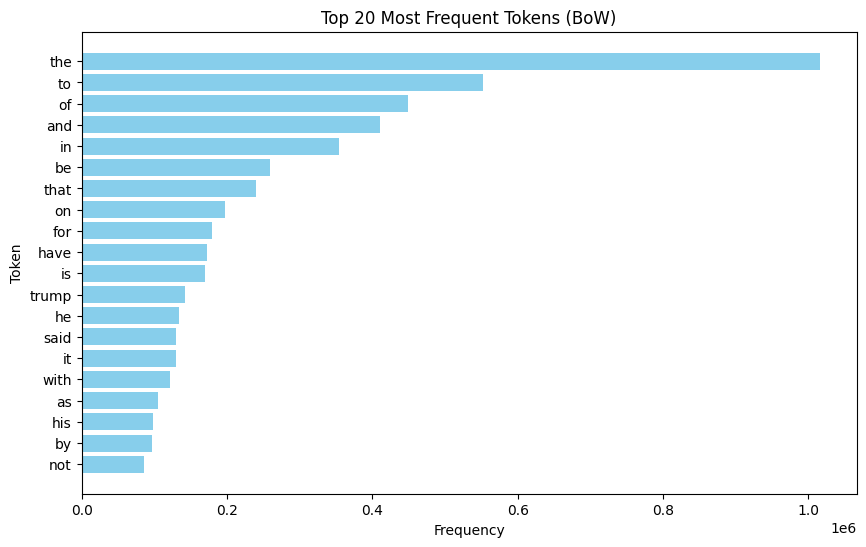

In [23]:
#get token counts (using BoW for this example)
word_counts= np.asarray(text_bow.sum(axis=0)).flatten()
vocab= bow_vectorizer.get_feature_names_out()

#create a dataFrame for top 20 tokens
freq_df= pd.DataFrame({'token': vocab, 'count': word_counts})
freq_df= freq_df.sort_values(by='count', ascending=False).head(20)

#plot
plt.figure(figsize=(10,6))
plt.barh(freq_df['token'][::-1], freq_df['count'][::-1], color='skyblue')
plt.title("Top 20 Most Frequent Tokens (BoW)")
plt.xlabel("Frequency")
plt.ylabel("Token")
plt.show()


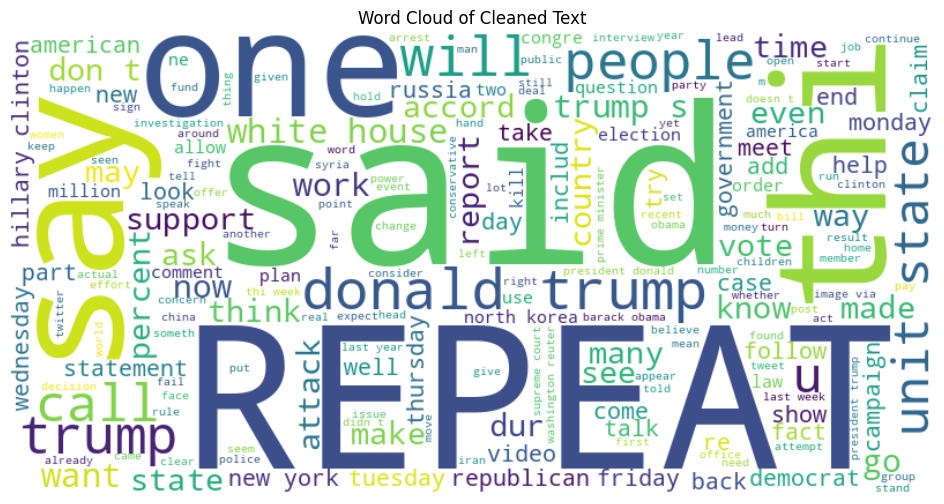

In [29]:
#join all text into a single string
all_text= ' '.join(data['clean_text'])

#generate word cloud
wordcloud= WordCloud(width=800, height=400, background_color='white').generate(all_text)

#plot
plt.figure(figsize=(15,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Text")
plt.show()


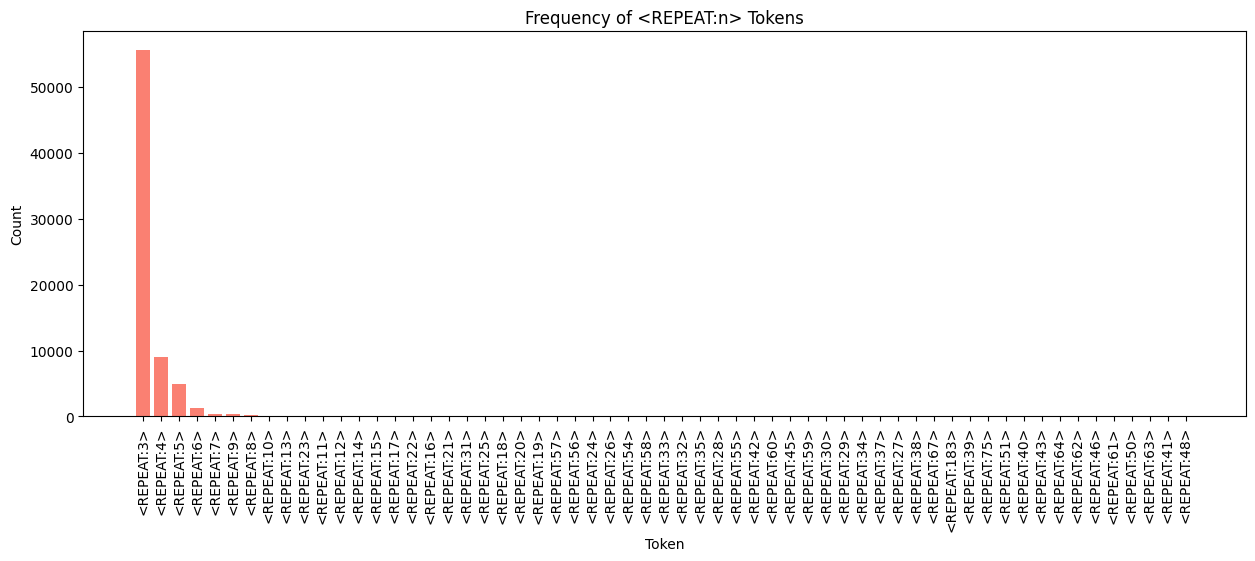

In [25]:
#find all tokens of the form <REPEAT:n>
repeat_tokens= data['clean_text'].str.findall(r'<REPEAT:\d+>')

#flatten list and count
repeats= Counter([token for sublist in repeat_tokens for token in sublist])

#convert to dataFrame for plotting
repeat_df= pd.DataFrame(repeats.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)

#Plot
plt.figure(figsize=(15,5))
plt.bar(repeat_df['token'], repeat_df['count'], color='salmon')
plt.xticks(rotation=90)
plt.title("Frequency of <REPEAT:n> Tokens")
plt.xlabel("Token")
plt.ylabel("Count")
plt.show()


Confusion matrix and ROC curves for each classifier.

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

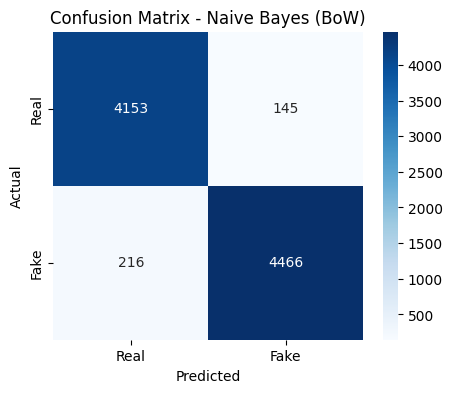

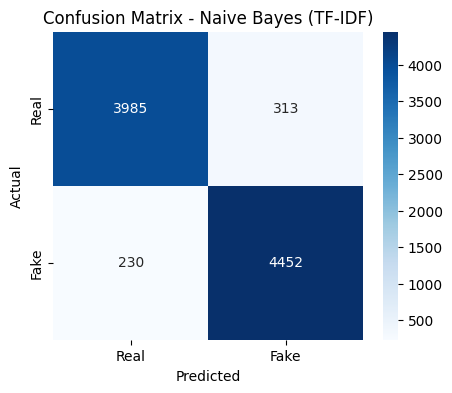

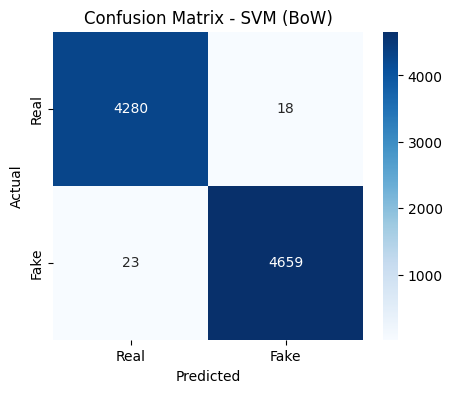

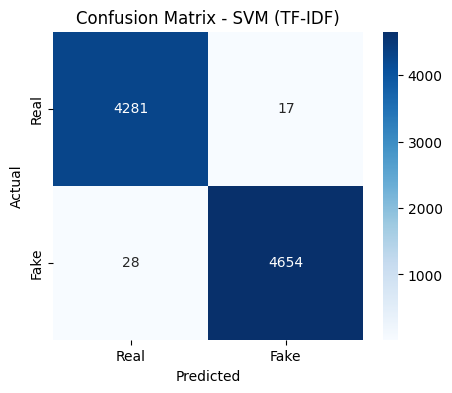

In [27]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm= confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


plot_confusion_matrix(y_test_bow, y_pred_nb_bow, "Naive Bayes (BoW)")
plot_confusion_matrix(y_test_tfidf, y_pred_nb_tfidf, "Naive Bayes (TF-IDF)")
plot_confusion_matrix(y_test_bow, y_pred_svm_bow, "SVM (BoW)")
plot_confusion_matrix(y_test_tfidf, y_pred_svm_tfidf, "SVM (TF-IDF)")

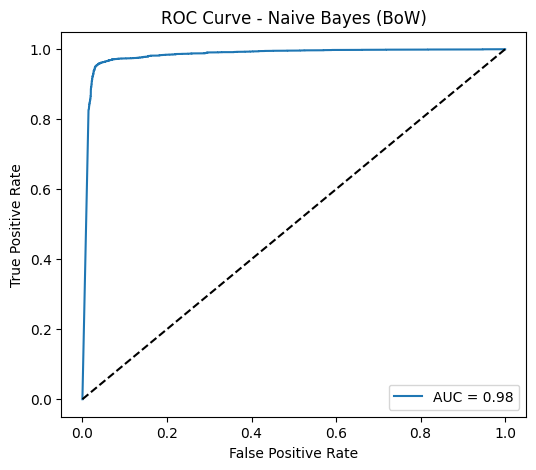

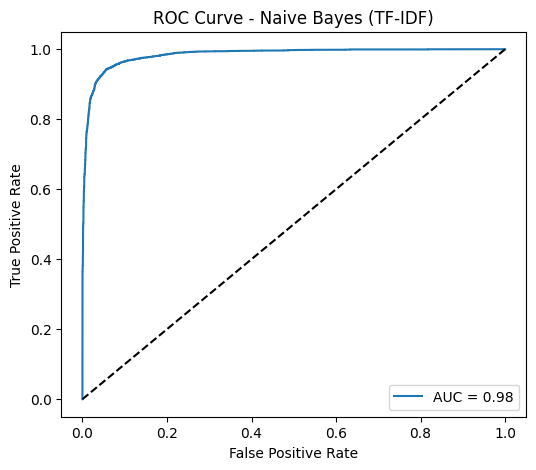

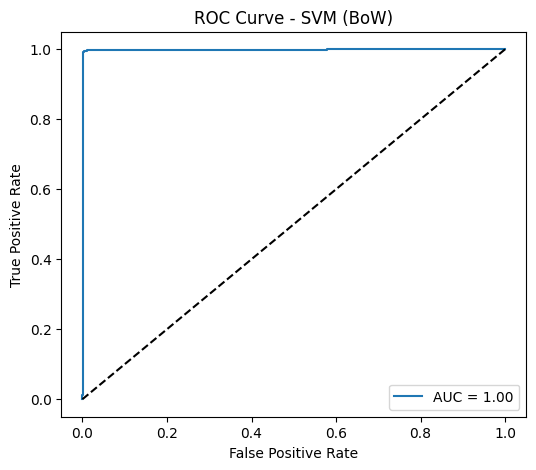

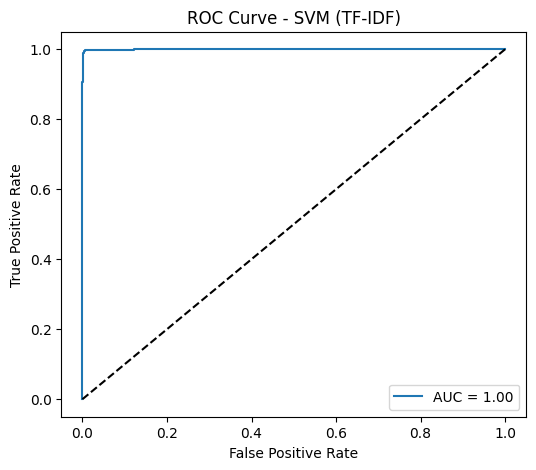

In [28]:
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, thresholds=roc_curve(y_true, y_scores)
    auc=roc_auc_score(y_true, y_scores)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc='lower right')
    plt.show()

#Naive Bayes (BoW)
y_scores_nb_bow=nb_bow.predict_proba(X_test_bow)[:,1]
plot_roc_curve(y_test_bow, y_scores_nb_bow, "Naive Bayes (BoW)")

#Naive Bayes (TF-IDF)
y_scores_nb_tfidf= nb_tfidf.predict_proba(X_test_tfidf)[:,1]
plot_roc_curve(y_test_tfidf, y_scores_nb_tfidf, "Naive Bayes (TF-IDF)")

#LinearSVC doesn't have predict_proba but has decision_function
#SVM (BoW) using decision function
y_scores_svm_bow= svm_bow.decision_function(X_test_bow)
plot_roc_curve(y_test_bow, y_scores_svm_bow, "SVM (BoW)")

#SVM (TF-IDF) using decision function
y_scores_svm_tfidf= svm_tfidf.decision_function(X_test_tfidf)
plot_roc_curve(y_test_tfidf, y_scores_svm_tfidf, "SVM (TF-IDF)")